In [1]:
# Imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from scipy.stats import chi2_contingency

## For loading data
from pathlib import Path
from typing import Union

In [2]:
def load_dataset(path: Union[Path, str]) -> pd.DataFrame:
    return pd.read_csv(path, index_col=0)


def load_rankings(path: Union[Path, str]) -> pd.DataFrame:
    out = pd.read_csv(path, index_col=0, header=[0, 1, 2, 3])
    out.columns.name = ("dataset", "model", "tuning", "scoring")
    return out

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Load data

In [4]:
dir_data = '../../data/raw/'

# File names
filename_dataset = 'dataset.csv'
filename_ranking = 'rankings.csv'

# Create paths for given files
filepath_dataset = os.path.join(dir_data, filename_dataset)
filepath_ranking = os.path.join(dir_data, filename_ranking)

# Load data
dataset = load_dataset(filepath_dataset)
rankings = load_rankings(filepath_ranking)

## Take a first look at the data for dataset.csv

__dataset.cvs__

Information already given by the course: 
- Five features
- All features are categrical
  - dataset: OpenML id of the dataset
  - model: abbreviation of ML model
  - tuning: how the model was tuned
  - scoring: evaluation metric for the model
  - encoder: encoder used
  - cv_score: evaluation $\rightarrow$ target for Regression task


Idea/Analysis: 
- Basic steps: 
  - Take a look at the data
  - Null-values
  - Distributions / counts
  - Data types
- Get unique values of the features
- Which encoder failed most in total?
- Which encoder failed most for each dataset/model/tuning/scoring?
- Which encoder succeeded most in total?
- Which encoder succeeded most for each dataset/model/tuning/scoring?

In [ ]:
dataset.shape

In [ ]:
dataset.head()

In [ ]:
dataset.info()

In [ ]:
dataset.describe(include='object')

In [ ]:
dataset.describe()

## Unique values

In [65]:
# Unique values
unique_encoders = dataset.encoder.unique()
unique_models = dataset.model.unique()
unique_tuning = dataset.tuning.unique()
unique_scoring = dataset.scoring.unique()
unique_datasets = dataset.dataset.unique()

print(f"Unique encoders: {len(unique_encoders)}\n{unique_encoders}\n\n")
print(f"Unique models  : {len(unique_models)}\n{unique_models}\n\n")
print(f"Unique tuning  : {len(unique_tuning)}\n{unique_tuning}\n\n")
print(f"Unique scoring : {len(unique_scoring)}\n{unique_scoring}\n\n")
print(f"Unique datasets: {len(unique_datasets)}\n{unique_datasets}\n\n")

Unique encoders: 32
['BE' 'BUCV10RGLMME' 'BUCV10TE' 'BUCV2RGLMME' 'BUCV2TE' 'BUCV5RGLMME'
 'BUCV5TE' 'CBE' 'CE' 'CV10RGLMME' 'CV10TE' 'CV2RGLMME' 'CV2TE'
 'CV5RGLMME' 'CV5TE' 'DE' 'DTEM10' 'DTEM2' 'DTEM5' 'ME01E' 'ME10E' 'ME1E'
 'MHE' 'OE' 'OHE' 'PBTE0001' 'PBTE001' 'PBTE01' 'RGLMME' 'SE' 'TE' 'WOEE']


Unique models  : 5
['DTC' 'KNC' 'LGBMC' 'LR' 'SVC']


Unique tuning  : 3
['full' 'model' 'no']


Unique scoring : 3
['ACC' 'AUC' 'F1']


Unique datasets: 50
[    3    29    31    38    50    51    56   333   334   451   470   881
   956   959   981  1037  1111  1112  1114  1169  1235  1461  1463  1486
  1506  1511  1590  6332 23381 40536 40945 40981 40999 41005 41007 41162
 41224 42178 42343 42344 42738 42750 43098 43607 43890 43892 43896 43897
 43900 43922]




### Conclusion for dataset.csv

- Five features (as already known and described above)
- No null-values
- Dataset ID is given as integer, but in fact categorical

## Distribution of every feature

In [ ]:
feature_set = list(dataset.columns)
feature_set.remove('cv_score')

counts = list()
idx = 0

NCOLS: int = 1
NROWS: int = 5

# Plot settings
fig, axes = plt.subplots(figsize=(15, 35), nrows=NROWS, ncols=NCOLS)
for feature, ax in zip(feature_set, axes.flatten()):
    # Group dataset
    sf = list()
    sf.append(feature_set[idx - 1])
    sf.append(feature_set[idx])
    
    tmp = dataset[sf].groupby([feature]).count().rename(columns={feature_set[idx - 1]: 'count'})
    tmp = tmp.reset_index()
    counts.append(tmp)
    
    # Plot counts
    g=sns.barplot(data=counts[idx], x=feature, y="count", color='b', ax=ax).set(title=feature)
    
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    
    # Increase counter 
    idx += 1
    
plt.tight_layout()
plt.show()

In [ ]:
# cv_score
sns.kdeplot(data=dataset, x='cv_score') 

#### Findings

(More or less) equally distributed among: 
- encoders
- scoring

Not equally distributed: 
- datasets: About half of the datasets have about 1100 rows, the other half between 500 and 800. 
- models: 'DTC', 'KNC' and 'LR' all have about 12000 data points. But 'SVC' only about 7000 and 'LGBMC' about 5000. 
- tuning: 'full' has the fewest data points (11000), 'model' about 14000 and 'no' the most with > 20000

### Do the features follow the same distribution among the encoders?

In [ ]:
# Are the models / tuning / scoring equally distributed among the encoders?
# One plot per encoder
count_per_encoder_model = dataset[['encoder', 'model', 'dataset']].groupby(['encoder', 'model']).count().rename(columns={'dataset': 'count'})
count_per_encoder_model = count_per_encoder_model.reset_index()


NCOLS: int = 4
NROWS: int = 8
fig, axes = plt.subplots(figsize=(15, 35), nrows=NROWS, ncols=NCOLS)

for encoder, ax in zip(unique_encoders, axes.flatten()):
    # Plot counts
    g=sns.barplot(data=count_per_encoder_model[count_per_encoder_model['encoder'] == encoder], 
                  x="model", 
                  y="count", 
                  color='b', 
                  ax=ax
                 ).set(title=f"Encoder: {encoder}")
    
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    
    # Increase counter 
    idx += 1
    
plt.tight_layout()
plt.show()

In [ ]:
# Are the models / tuning / scoring equally distributed among the encoders?
# One plot per encoder
count_per_encoder_model = dataset[['encoder', 'tuning', 'dataset']].groupby(['encoder', 'tuning']).count().rename(columns={'dataset': 'count'})
count_per_encoder_model = count_per_encoder_model.reset_index()


NCOLS: int = 4
NROWS: int = 8
fig, axes = plt.subplots(figsize=(15, 35), nrows=NROWS, ncols=NCOLS)

for tuning, ax in zip(unique_encoders, axes.flatten()):
    # Plot counts
    g=sns.barplot(data=count_per_encoder_model[count_per_encoder_model['encoder'] == encoder], 
                  x="tuning", 
                  y="count", 
                  color='b', 
                  ax=ax
                 ).set(title=f"Encoder: {encoder}")
    
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    
    # Increase counter 
    idx += 1
    
plt.tight_layout()
plt.show()

In [ ]:
# Are the models / tuning / scoring equally distributed among the encoders?
# One plot per encoder
count_per_encoder_model = dataset[['encoder', 'scoring', 'dataset']].groupby(['encoder', 'scoring']).count().rename(columns={'dataset': 'count'})
count_per_encoder_model = count_per_encoder_model.reset_index()


NCOLS: int = 4
NROWS: int = 8
fig, axes = plt.subplots(figsize=(15, 35), nrows=NROWS, ncols=NCOLS)

for encoder, ax in zip(unique_encoders, axes.flatten()):
    # Plot counts
    g=sns.barplot(data=count_per_encoder_model[count_per_encoder_model['encoder'] == encoder], 
                  x="scoring", 
                  y="count", 
                  color='b', 
                  ax=ax
                 ).set(title=f"Encoder: {encoder}")
    
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    
    # Increase counter 
    idx += 1
    
plt.tight_layout()
plt.show()

#### Findings

Distribution among the encoders is the same as over the whole dataset

### Correlation between features

In [ ]:
def plot_cramers_v_corr_heatmap(data=None, features_x_axis=None, features_y_axis=None, annotate_map=True):
    """
    Calculates the cramers V correlation of all features and plots them in a heatmap. 
    Cramers V is based on Chi square, for reference see: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    Note that this function is desined to work for categorical features only!
    Code was copied and modified from this source: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook
    
    :param data: Dataframe with features and values
    :param features_x_axis: The features to plot on the x axis
    :param features_y_axis: The features to plot on the y axis
    """
    # Encode features
    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame() 

    for i in data.columns :
        data_encoded[i]=label.fit_transform(data[i])

    # Internal function to calculate cramers V for two features
    def _cramers_V(var1, var2) :
        crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))  # Cross table building
        stat = chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab)  # Number of observations
        mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
        return (stat / (obs * mini))
        #return stat

    # Calculate values for each pair of features
    rows= []
    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers = _cramers_V(data_encoded[var1], data_encoded[var2])  # Cramer's V test
            col.append(round(cramers, 4))  # Keeping of the rounded value of the Cramer's V  
        rows.append(col)
    
    # Create a pandas df from the results
    cramers_results = np.array(rows)
    cramers_v_corr_matrix = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
    
    # Set features for axis
    if features_x_axis is None: 
        features_x_axis = list(data.columns)
    if features_y_axis is None:
        features_y_axis = list(data.columns)
    
    # Plot correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(cramers_v_corr_matrix[features_x_axis].loc[features_y_axis], annot=annotate_map, cmap=plt.cm.Reds)
    plt.show()

In [ ]:
%%time

cat_feature_list = ['encoder', 'dataset', 'model', 'tuning', 'scoring']
plot_cramers_v_corr_heatmap(data=dataset, features_x_axis=cat_feature_list, features_y_axis=cat_feature_list)

## Take a first look at the data for rankings.csv

In [5]:
rankings.shape

(32, 1548)

In [6]:
rankings.head()

3                                       ... 43922               
              DTC                                  KNC  ...    LR               
             full        model          no        full  ... model  no           
              ACC AUC F1   ACC AUC  F1 ACC AUC F1  ACC  ...    F1 ACC AUC  F1   
encoder                                                 ...                     
BE              1   1  1    12  12  12   1   1  1   21  ...     7   8   8   6  \
BUCV10RGLMME    1   1  1    14  14  13   1   1  1   16  ...    12  10  10  10   
BUCV10TE        1   1  1     0   0   0   1   1  1    9  ...    11   9   9   9   
BUCV2RGLMME     1   1  1    18  18  18   1   1  1   15  ...    18  14  14  14   
BUCV2TE         1   1  1     6   6   6   1   1  1    8  ...    15  13  13  13   

                                       
              SVC                      
             full          no          
              ACC AUC  F1 ACC AUC  F1  
encoder                                
BE              0   0   4   4   4   4  
BUCV10RGLMME   14  14  10  21  21  21  
BUCV10TE       14  14  10  12  12  12  
BUCV2RGLMME    19  19  19   7   7   8  
BUCV2TE        21  21  21   8   8   7  

[5 rows x 1548 columns]

Pay attention to the multi-index

In [7]:
rankings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, BE to WOEE
Columns: 1548 entries, ('3', 'DTC', 'full', 'ACC') to ('43922', 'SVC', 'no', 'F1')
dtypes: float64(331), int64(1217)
memory usage: 387.2+ KB


In [8]:
rankings['3'].describe()

DTC                                                          
            full                            model                         
             ACC        AUC         F1        ACC        AUC         F1   
count  32.000000  32.000000  32.000000  32.000000  32.000000  32.000000  \
mean    1.125000   1.125000   1.125000  10.718750  10.718750  10.718750   
std     0.707107   0.707107   0.707107   7.833898   7.833898   7.833898   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     1.000000   1.000000   1.000000   3.000000   3.000000   3.000000   
50%     1.000000   1.000000   1.000000   9.500000   9.500000   9.500000   
75%     1.000000   1.000000   1.000000  17.250000  17.250000  17.250000   
max     4.000000   4.000000   4.000000  25.000000  25.000000  25.000000   

                                              KNC  ...         LR              
              no                             full  ...      model         no   
             ACC        AUC         F1        ACC  ...         F1        ACC   
count  32.000000  32.000000  32.000000  32.000000  ...  32.000000  32.000000  \
mean    1.125000   1.125000   1.125000  13.437500  ...  15.500000  11.812500   
std     0.707107   0.707107   0.707107   8.296667  ...   9.380832   6.855361   
min     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%     1.000000   1.000000   1.000000   6.750000  ...   7.750000   6.750000   
50%     1.000000   1.000000   1.000000  12.500000  ...  15.500000  13.000000   
75%     1.000000   1.000000   1.000000  20.250000  ...  23.250000  16.250000   
max     4.000000   4.000000   4.000000  28.000000  ...  31.000000  24.000000   

                                   SVC                                   
                                  full                              no   
             AUC         F1        ACC        AUC         F1       ACC   
count  32.000000  32.000000  32.000000  32.000000  32.000000  32.00000  \
mean   13.500000  13.906250  15.406250  15.406250  15.343750  12.87500   
std     7.745967   8.145291   9.231291   9.231291   9.139102   7.92607   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.00000   
25%     7.750000   7.750000   7.750000   7.750000   7.750000   6.75000   
50%    14.000000  14.500000  15.500000  15.500000  15.500000  12.00000   
75%    19.250000  20.250000  23.250000  23.250000  23.250000  19.25000   
max    27.000000  28.000000  29.000000  29.000000  29.000000  27.00000   

                             
                             
             AUC         F1  
count  32.000000  32.000000  
mean   15.000000  14.937500  
std     8.944272   8.951257  
min     0.000000   0.000000  
25%     7.750000   7.750000  
50%    15.000000  14.500000  
75%    22.250000  22.250000  
max    30.000000  30.000000  

[8 rows x 36 columns]

In [19]:
# Count of null values for each encoder
rankings.isna().sum(1)

encoder
BE               27
BUCV10RGLMME     88
BUCV10TE         42
BUCV2RGLMME      60
BUCV2TE           9
BUCV5RGLMME      82
BUCV5TE          27
CBE               9
CE               12
CV10RGLMME       71
CV10TE            9
CV2RGLMME        54
CV2TE             9
CV5RGLMME        62
CV5TE             9
DE               15
DTEM10            6
DTEM2            12
DTEM5             6
ME01E            47
ME10E            39
ME1E             48
MHE             165
OE                4
OHE             130
PBTE0001        123
PBTE001          33
PBTE01           36
RGLMME           57
SE              175
TE                9
WOEE             15
dtype: int64

In [22]:
rankings.isna().sum(1).sum()

1490

In [26]:
null_values_per_column = rankings.isna().sum(0)
null_values_per_column_filtered = null_values_per_column[null_values_per_column > 0]

In [40]:
print(null_values_per_column_filtered.index)

nv_datasets = list(set([int(x[0]) for x in null_values_per_column_filtered.index]))
nv_datasets.sort()
print(f"Datasets with null values  : {len(nv_datasets)} \n{nv_datasets}\n")

nv_models = list(set([x[1] for x in null_values_per_column_filtered.index]))
nv_models.sort()
print(f"Models with null values  : {len(nv_models)} \n{nv_models}\n")

nv_tuning = list(set([x[2] for x in null_values_per_column_filtered.index]))
nv_tuning.sort()
print(f"Tuning with null values  : {len(nv_tuning)} \n{nv_tuning}\n")

nv_scoring = list(set([x[3] for x in null_values_per_column_filtered.index]))
nv_scoring.sort()
print(f"Scoring with null values : {len(nv_scoring)} \n{nv_scoring}\n")

MultiIndex([(   '50', 'DTC', 'model', 'ACC'),
            (   '50', 'DTC', 'model', 'AUC'),
            (   '50', 'DTC', 'model',  'F1'),
            (   '50', 'KNC', 'model', 'ACC'),
            (   '50', 'KNC', 'model', 'AUC'),
            (   '50', 'KNC', 'model',  'F1'),
            (  '959', 'DTC', 'model', 'ACC'),
            (  '959', 'DTC', 'model', 'AUC'),
            (  '959', 'DTC', 'model',  'F1'),
            (  '959', 'DTC',    'no', 'ACC'),
            ...
            ('43900', 'DTC', 'model',  'F1'),
            ('43900', 'KNC', 'model', 'ACC'),
            ('43900', 'KNC', 'model', 'AUC'),
            ('43900', 'KNC', 'model',  'F1'),
            ('43900',  'LR', 'model', 'ACC'),
            ('43900',  'LR', 'model', 'AUC'),
            ('43900',  'LR', 'model',  'F1'),
            ('43900', 'SVC',    'no', 'ACC'),
            ('43900', 'SVC',    'no', 'AUC'),
            ('43900', 'SVC',    'no',  'F1')],
           length=331)
Datasets with null values  : 19 
[50, 95

#### Findings

Total null values: 1490
    
There is no encoder without null values

There are datasets which have no null values. But despite this the null values occur everywhere. 

## Which encoder failed most in total?

- Which encoder has the worst mean?
- Which encoder has the worst median?

In [47]:
column_count = rankings.shape[1]

1548

In [88]:
# Get number ranks per encoder
max_rank_per_encoder = rankings.max(axis='columns')

In [95]:
total_stats[['mean', 'median']].columns

MultiIndex([(  'mean', '', '', ''),
            ('median', '', '', '')],
           )

In [99]:
# Calculate mean
total_stats = rankings.copy()
total_stats['mean'] = rankings.mean(axis=1)
total_stats['median'] = rankings.median(axis=1)
total_stats[['mean', 'median']].sort_values(by=[('mean', '', '', ''), ('median', '', '', '')]).head(32)

,mean,median
,,
,,
,,
encoder,,
OHE,7.079690,4.0
WOEE,7.275930,5.0
BE,7.869165,5.0
SE,7.965040,5.0
BUCV10TE,9.237052,6.0
BUCV10RGLMME,9.436301,8.0


#### Findings

Above we can see a total ranking of the encoders

## Rankings per feature

Column index levels:

0: dataset

1: model

2: tuning

3: scoring

In [77]:
rankings_dataset = rankings.groupby(level=0, axis='columns').mean().mean()
rankings_dataset.sort_values()

959       0.110000
43897     1.301215
451       1.486979
41224     3.180244
43890     3.622153
1235      4.103621
56        5.062500
1506      5.546007
1511      6.292535
333       7.060764
43892     7.600694
40999     7.779514
881       7.830729
41005     8.188368
334       8.398438
1111      8.801075
1463      9.030382
40945     9.250000
38        9.408854
43896    10.413194
29       10.606771
40981    10.752604
43098    10.815972
41007    10.879340
51       11.110677
42750    11.190195
3        11.344618
956      11.355035
1114     11.636841
1486     11.687500
42343    11.759579
1112     11.764209
31       12.198785
50       12.456076
1590     12.582544
43922    12.703125
23381    13.237847
1461     13.264946
470      13.402778
1037     13.559028
42344    13.728611
6332     13.743924
42738    14.098041
1169     14.115650
43607    14.181452
43900    14.181771
42178    14.240885
41162    14.796652
40536    14.834201
981      15.325521
dtype: float64

In [78]:
rankings_model = rankings.groupby(level=1, axis='columns').mean().mean()
rankings_model.sort_values()

SVC       8.932920
DTC       8.964162
LGBMC    10.034148
LR       10.733872
KNC      11.426816
dtype: float64

In [79]:
rankings_tuning = rankings.groupby(level=2, axis='columns').mean().mean()
rankings_tuning.sort_values()

full      9.985676
no       10.009084
model    10.417620
dtype: float64

In [80]:
rankings_scoring = rankings.groupby(level=3, axis='columns').mean().mean()
rankings_scoring.sort_values()

ACC     8.984934
AUC    10.629499
F1     10.753179
dtype: float64

#### Findings

- In the datasets the variance is very high. On some datasets all encoders work very good. For example on dataset 959 or 43892, but on others most encoders are not that good. 
- In the tuning there is no such a high variance
- In scoring and model there is only small variance

## Rankings per encoder and feature

In [81]:
rankings_by_encoder_dataset = rankings.copy()
rankings_by_encoder_dataset_mean = rankings_by_encoder_dataset.groupby(level=0, axis='columns').mean()
rankings_by_encoder_dataset_median = rankings_by_encoder_dataset.groupby(level=0, axis='columns').median()

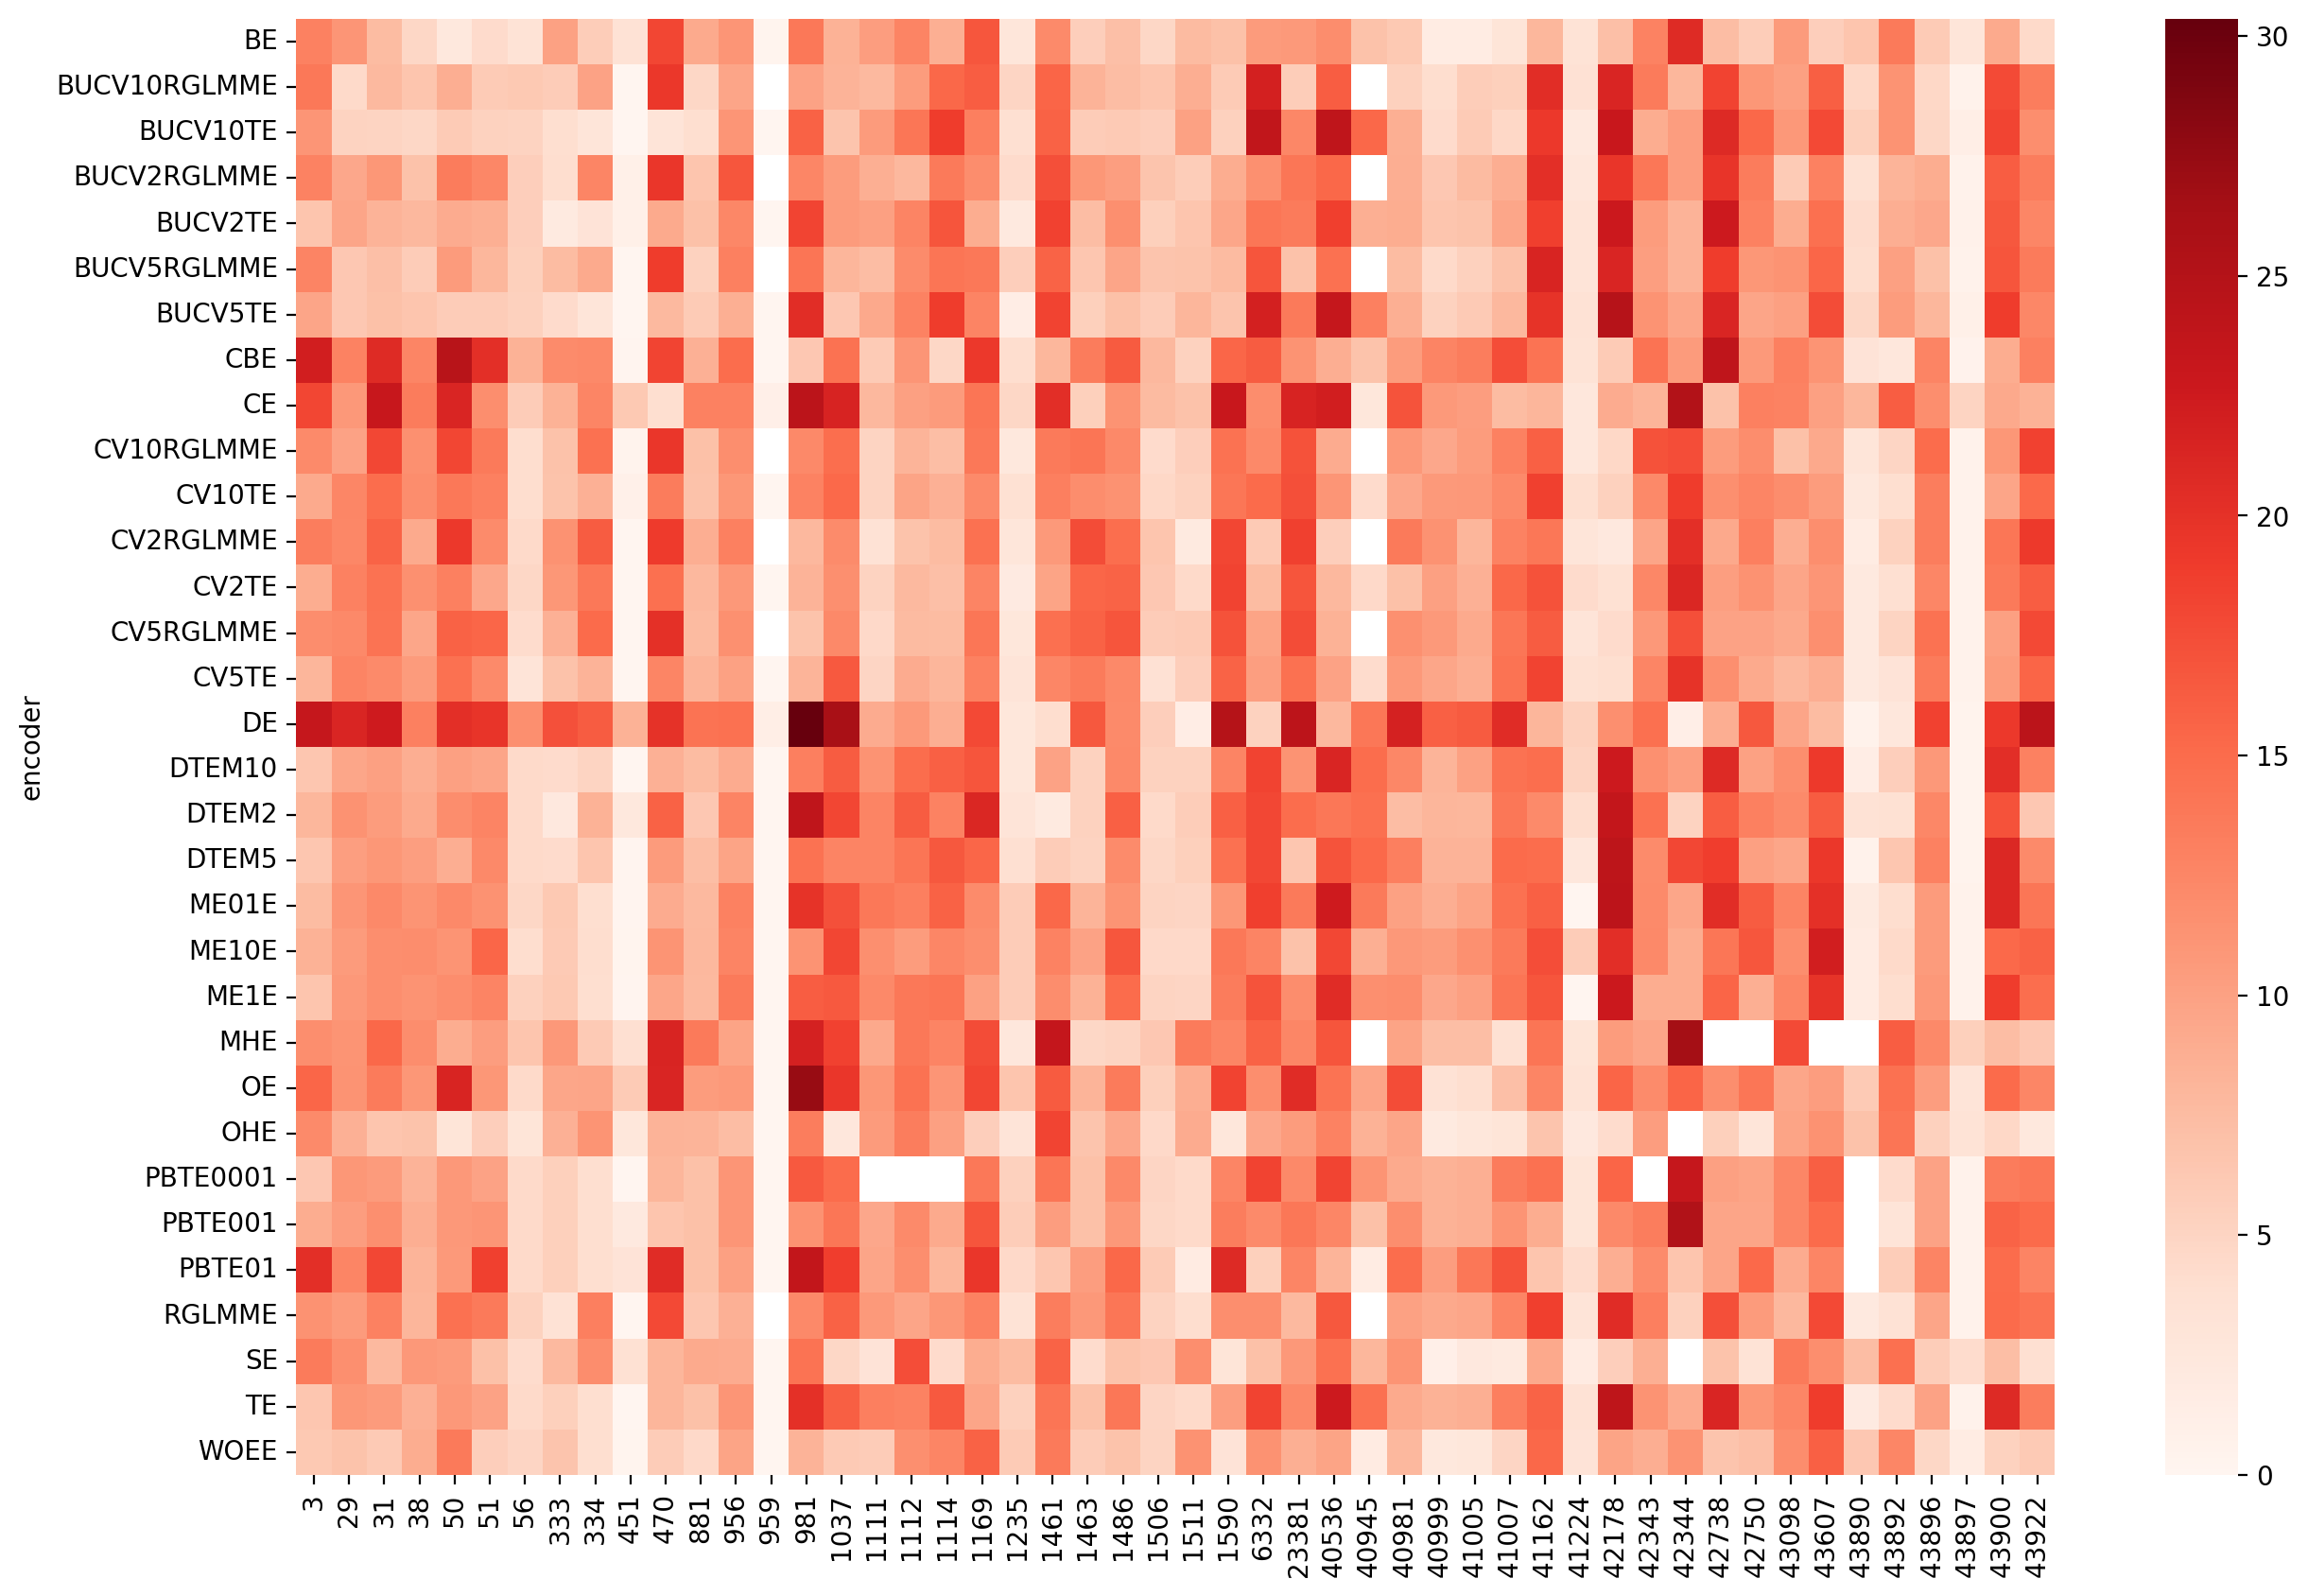

In [82]:
# Plot heatmap for mean of dataset per encoder
# Plot correlations
plt.figure(figsize=(15, 10))
unique_datasets = [str(x) for x in unique_datasets]
sns.heatmap(rankings_by_encoder_dataset_mean[unique_datasets], annot=False, cmap=plt.cm.Reds)
plt.show()

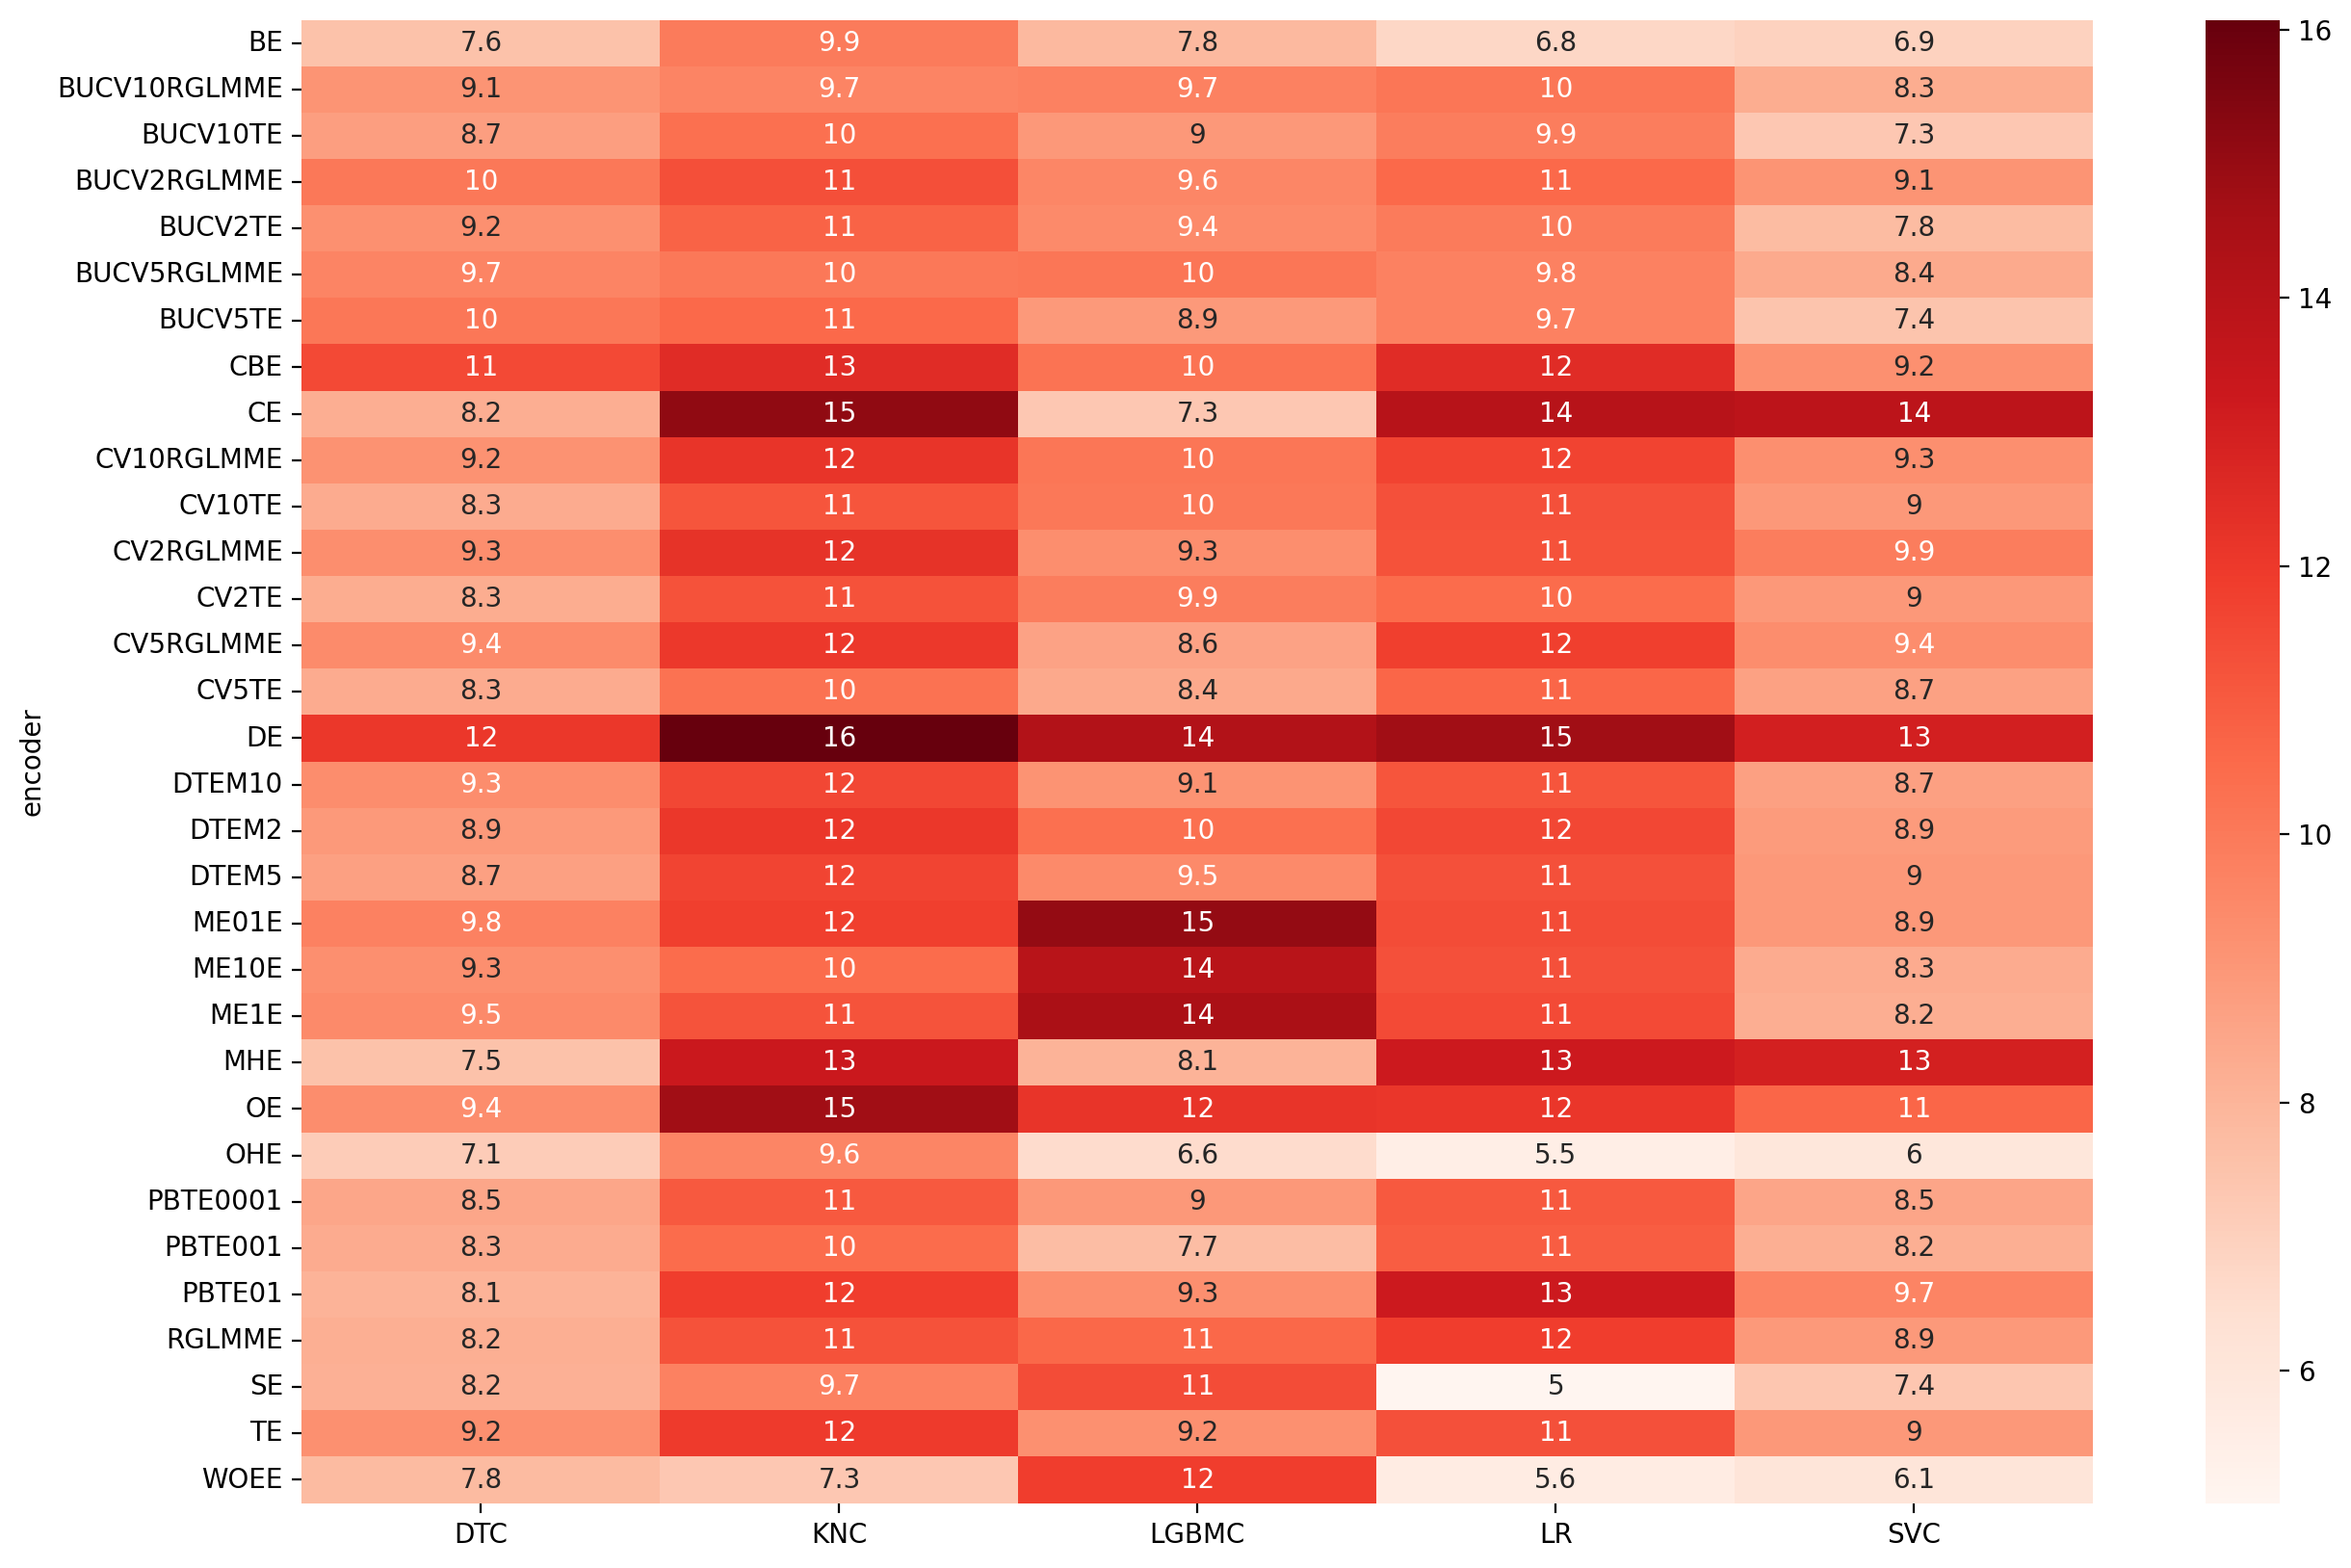

In [105]:
rankings_by_encoder_model_mean = rankings.groupby(level=1, axis='columns').mean()

plt.figure(figsize=(15, 10))
sns.heatmap(rankings_by_encoder_model_mean[unique_models], annot=True, cmap=plt.cm.Reds)
plt.show()

The encoder 'DE' seems to be not good for all models

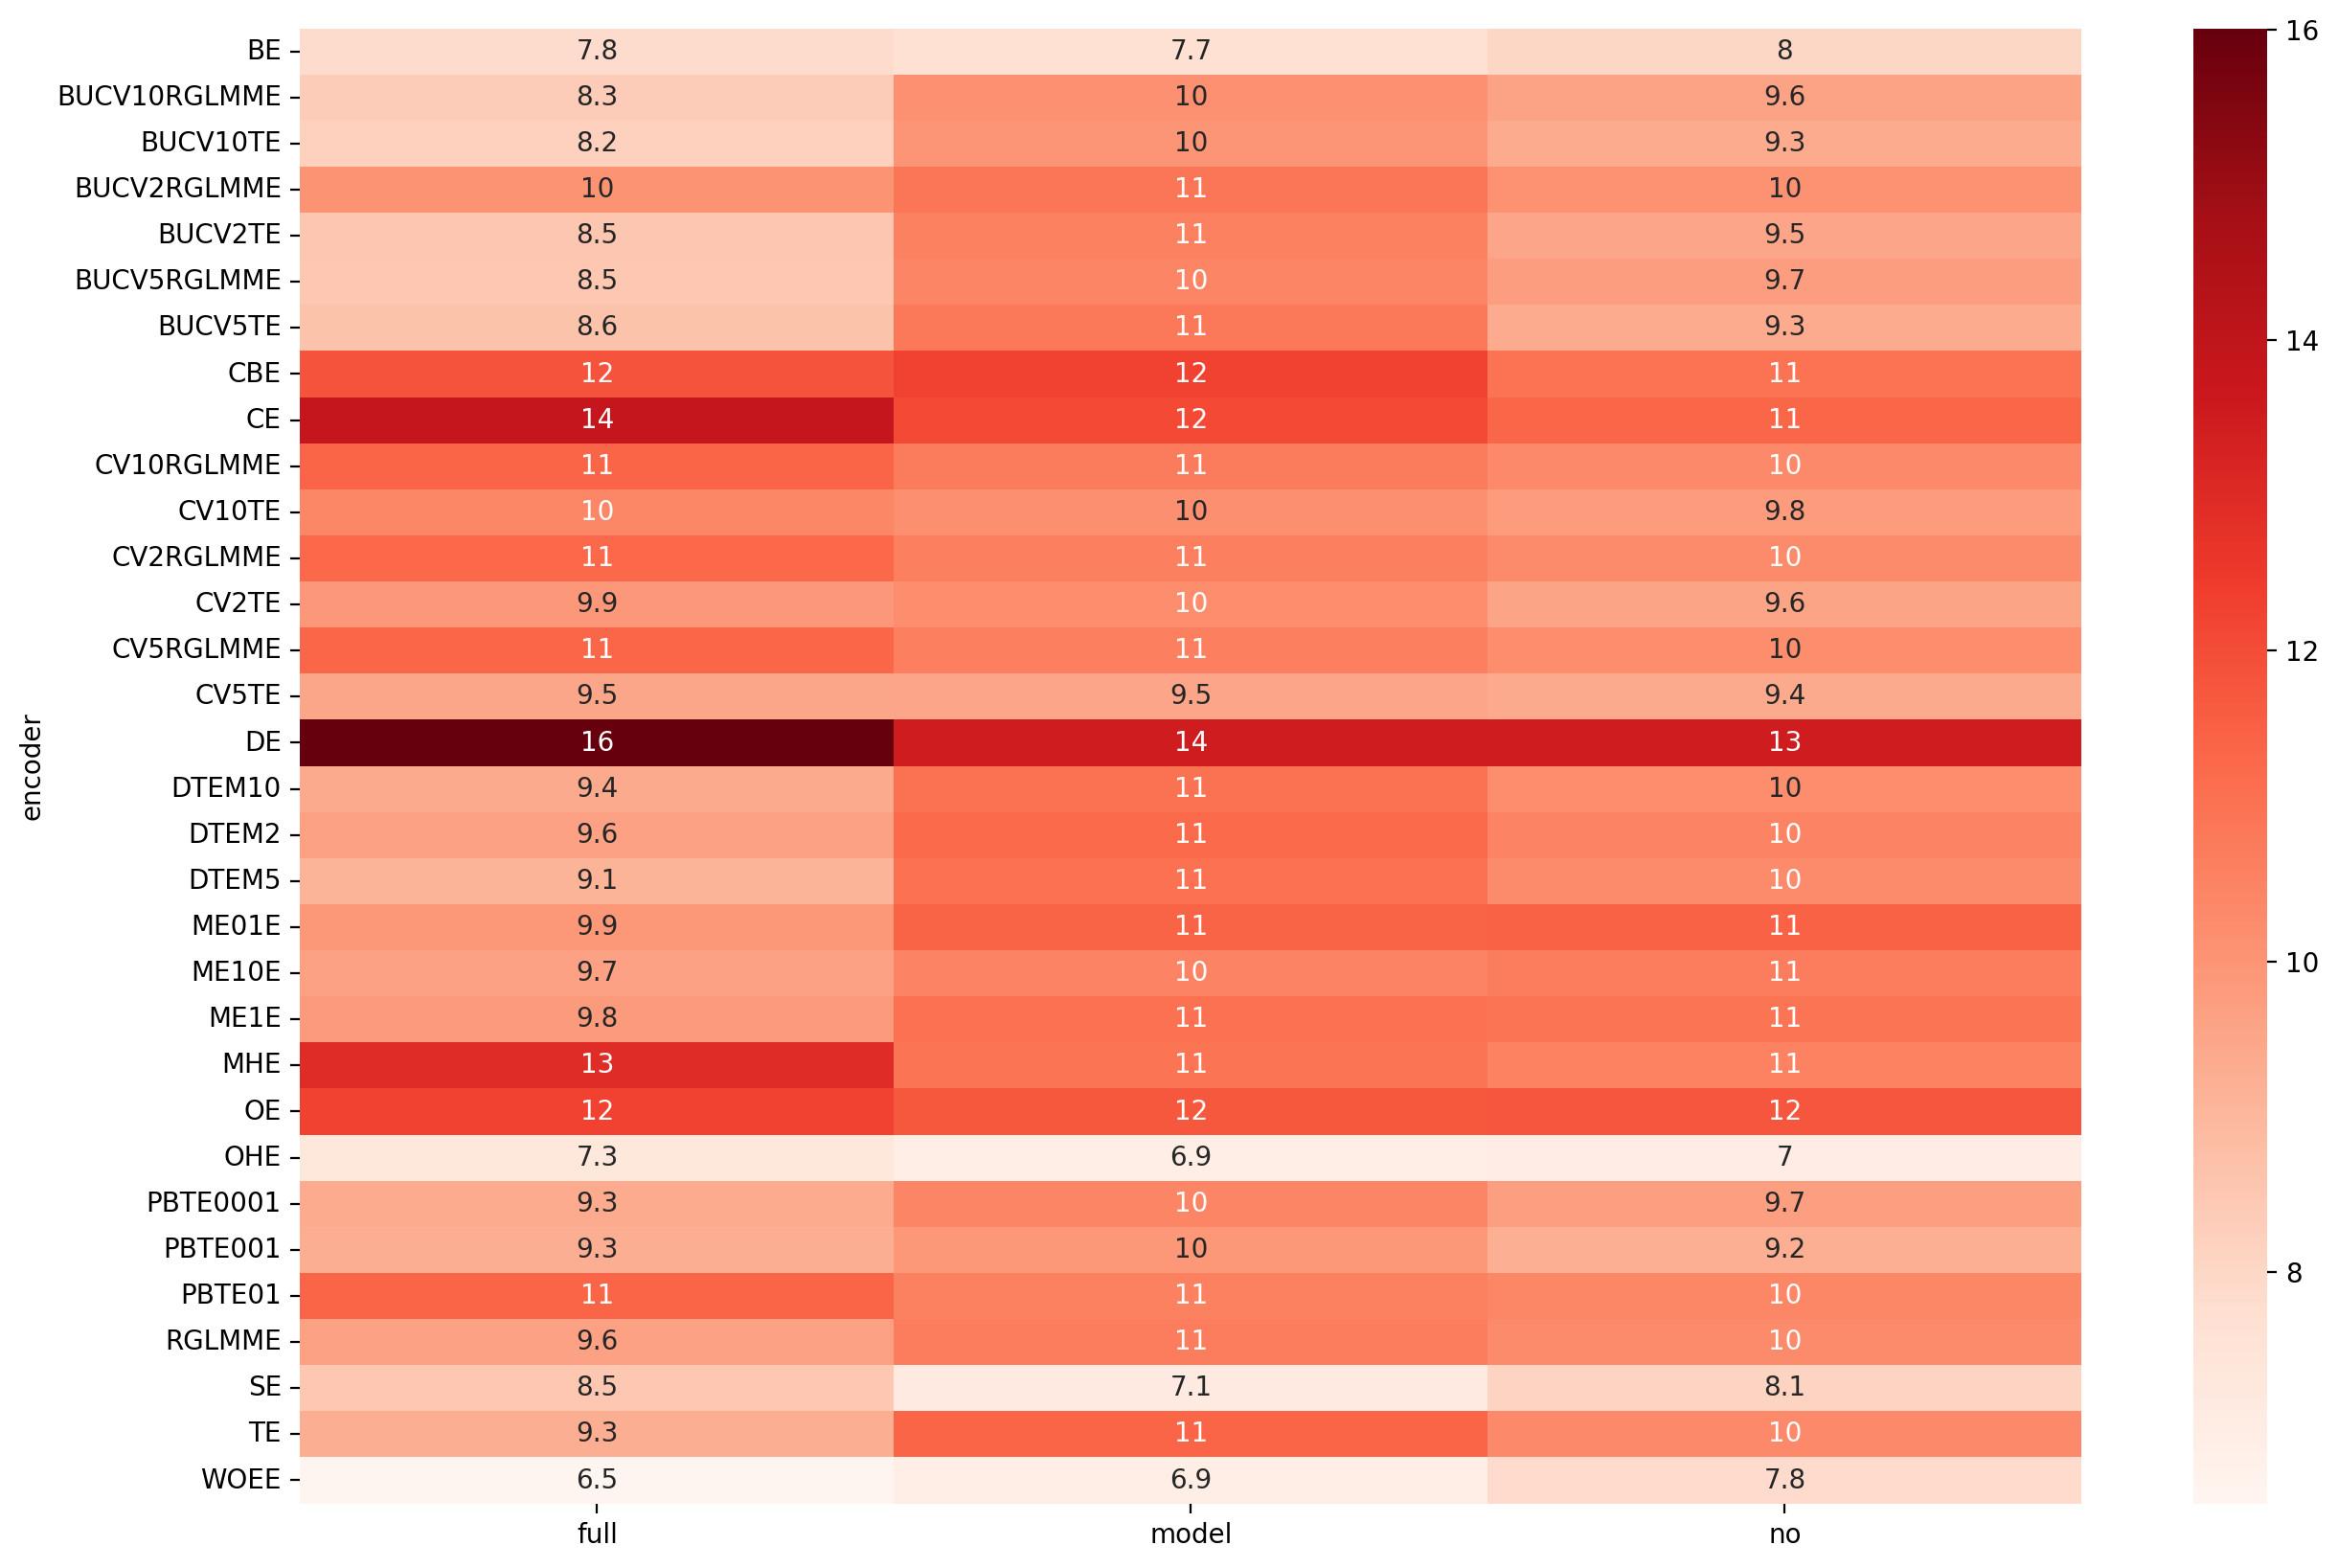

In [106]:
rankings_by_encoder_tuning_mean = rankings.groupby(level=2, axis='columns').mean()

plt.figure(figsize=(15, 10))
sns.heatmap(rankings_by_encoder_tuning_mean[unique_tuning], annot=True, cmap=plt.cm.Reds)
plt.show()

One cannot see a direct connection between the tuning method and the quality of the encoder

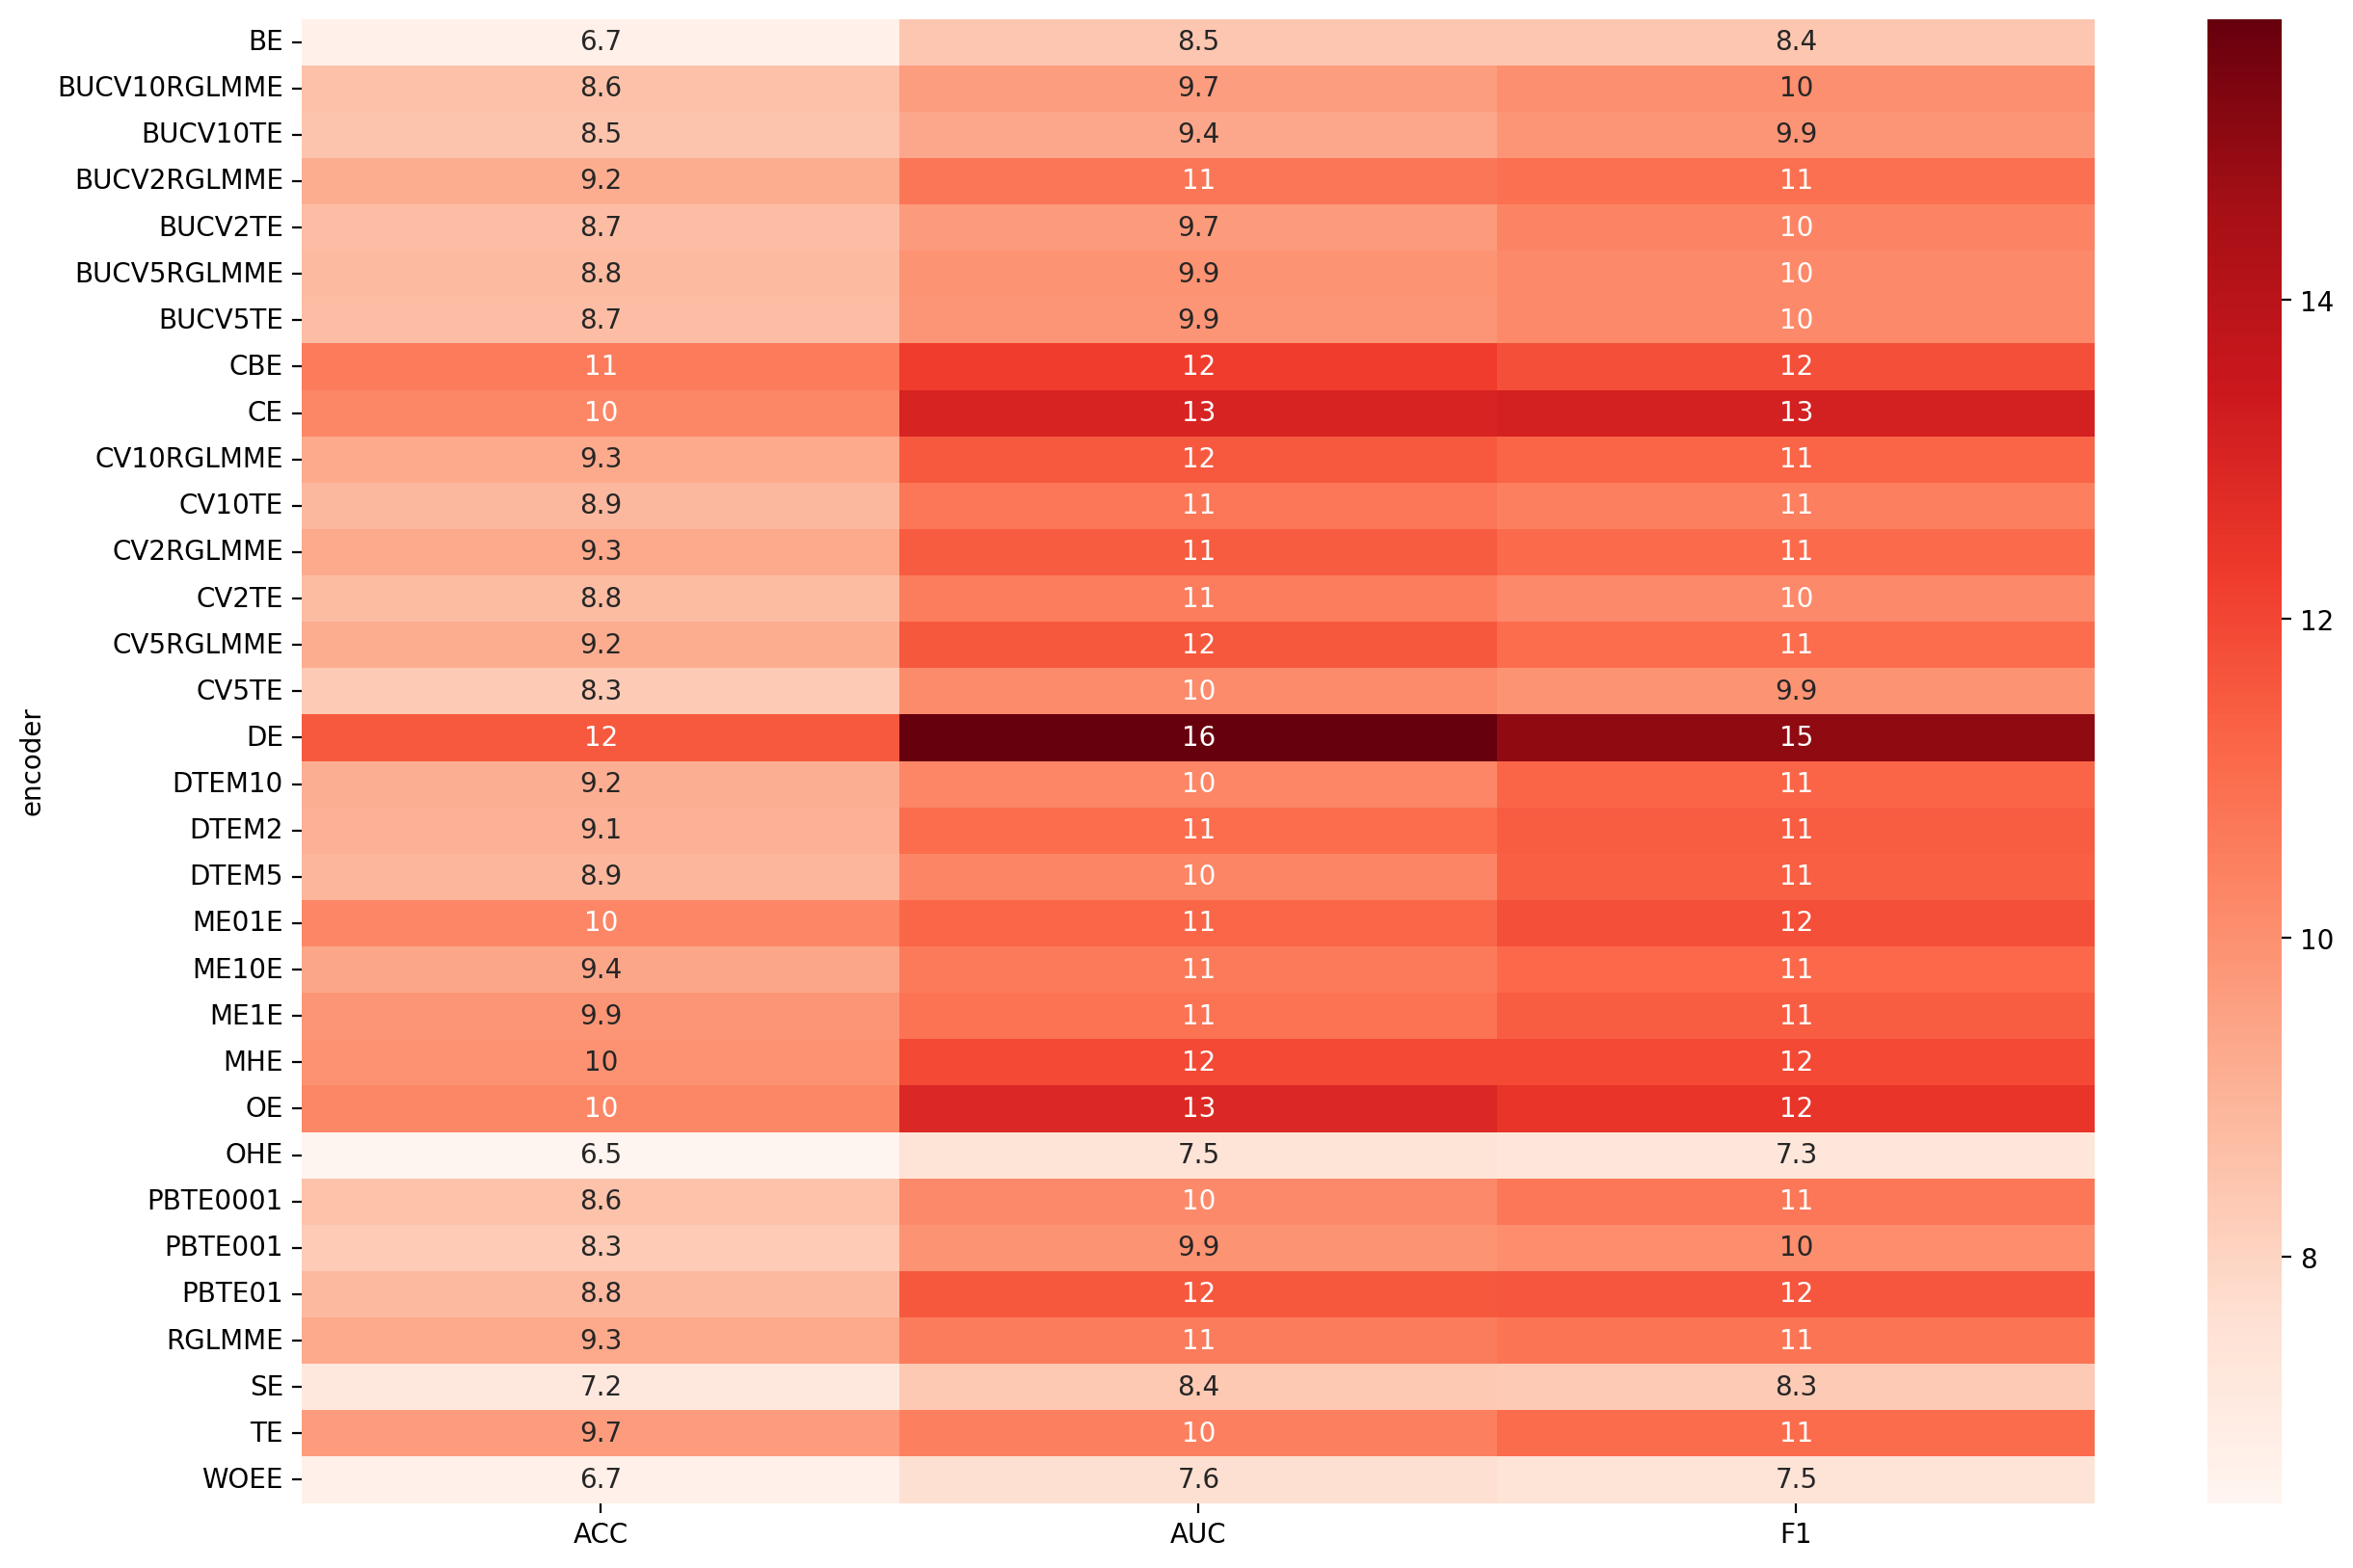

In [107]:
rankings_by_encoder_scoring_mean = rankings.groupby(level=3, axis='columns').mean()

plt.figure(figsize=(15, 10))
sns.heatmap(rankings_by_encoder_scoring_mean[unique_scoring], annot=True, cmap=plt.cm.Reds)
plt.show()

In average all encoders have a better rank when using ACC as scoring